In [4]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import os

pd.set_option('display.max_columns', 500)

1. ¿cuál es el PROBLEMA que quiero resolver? (de aquí saldrán las hipótesis y objetivos, entre más detalle mejor)

Se puede determinar cuanto tiempo va a jugar una persona con los valores de los datos?
Objetivo.- Visualizar los factores mas importantes para que un juego sea jugado por mucho tiempo

2. ¿cuál sería el RESULTADO ESPERADO del análisis? (aquí hay que pensar en ingeniería inversa; del resultado esperado, definiendo cada módulo que me hará llegar a ese resultado, hasta el planteamiento del problema, que es donde inicia el proyecto)

Esperamos observar varios juegos online o sin historia como aquellos con mas tiempo jugado. Ademas, estos juegos pertenecen a una empresa grande. 

3. ¿CÓMO pienso resolverlo? (QUÉ voy a ocupar y CÓMO pienso usarlo)

Mucha limpieza de datos y Regresion 

In [6]:
df_steam = pd.read_csv('steam.csv')
# Dado que queremos predecir el tiempo de juego, solo tomaremos aquellos que tengo algun registro
df_steam = df_steam[df_steam['average_playtime'] > 0]
# Facilidad para manejar la columna posteriormente
df_steam.rename(columns={'steamspy_tags': 'tags'}, inplace=True)
# Columnas inutiles
df_steam.drop(['english', 'required_age', 'appid'], axis=1, inplace=True)

## Estadística Descrptiva

In [37]:
df_steam.head()

,name,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,year,month,rating,rat_count,linux,mac,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
0,Counter-Strike,0,78.275556,1.408889,20000000,7.19,225,2000,11,97.388815,127873,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Team Fortress Classic,0,1.135246,0.254098,10000000,3.99,244,1999,4,83.978740,3951,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Day of Defeat,0,0.963918,0.175258,10000000,3.99,194,2003,5,89.564761,3814,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Deathmatch Classic,0,1.183486,0.844037,10000000,3.99,218,2001,6,82.662338,1540,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Half-Life: Opposing Force,0,2.632911,1.751055,10000000,3.99,237,1999,11,94.799567,5538,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [39]:
df_steam.shape

(6170, 141)

In [40]:
df_steam.describe()

,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,year,month,rating,rat_count,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
count,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.00000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000
mean,46.662723,27.780692,27.518271,7.236904e+05,7.472110,46.392545,

In [41]:
df_steam.name.unique()

array(['Counter-Strike', 'Team Fortress Classic', 'Day of Defeat', ...,
       '東方幕華祭 春雪篇 ～ Fantastic Danmaku Festival Part II',
       'Lovers of Aether', 'Paper Dolls: Original / 纸人：第一章'], dtype=object)

In [42]:
df_steam.year.unique()

array([2000, 1999, 2003, 2001, 1998, 2004, 2010, 2005, 2006, 2007, 2008,
       2009, 2013, 2011, 2012, 2014, 2015, 2017, 2016, 2002, 2018, 2019,
       1997], dtype=int64)

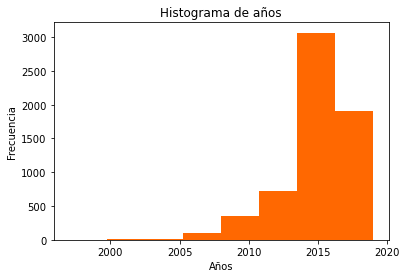

In [44]:
plt.hist(x=df_steam['year'], bins= 8,color= '#FF6801')
plt.title("Histograma de años")
plt.xlabel('Años')
plt.ylabel('Frecuencia')


plt.show()

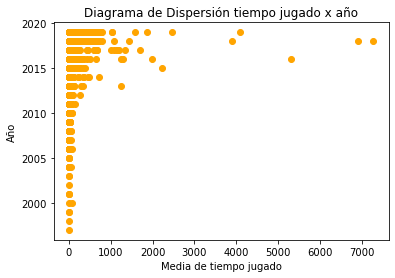

In [47]:
plt.plot(df_steam['average_playtime'],df_steam['year'],'o', color= "orange")
plt.xlabel("Media de tiempo jugado")
plt.ylabel("Año")
plt.title("Diagrama de Dispersión tiempo jugado x año")

plt.show()

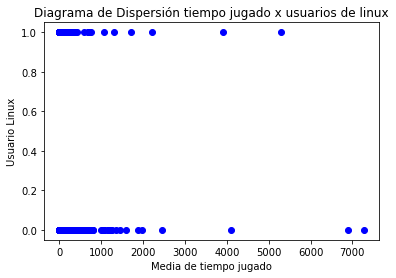

In [48]:
plt.plot(df_steam['average_playtime'],df_steam['linux'],'o', color= "blue")
plt.xlabel("Media de tiempo jugado")
plt.ylabel("Usuario Linux")
plt.title("Diagrama de Dispersión tiempo jugado x usuarios de linux")

plt.show()

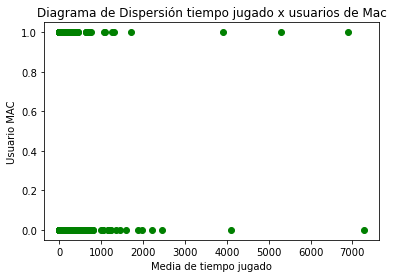

In [49]:
plt.plot(df_steam['average_playtime'],df_steam['mac'],'o', color= "green")
plt.xlabel("Media de tiempo jugado")
plt.ylabel("Usuario MAC")
plt.title("Diagrama de Dispersión tiempo jugado x usuarios de Mac")

plt.show()

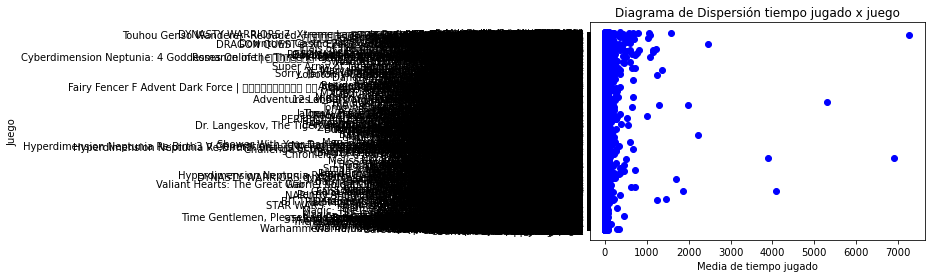

In [50]:
plt.plot(df_steam['average_playtime'],df_steam['name'],'o', color= "blue")
plt.xlabel("Media de tiempo jugado")
plt.ylabel("Juego")
plt.title("Diagrama de Dispersión tiempo jugado x juego")

plt.show()

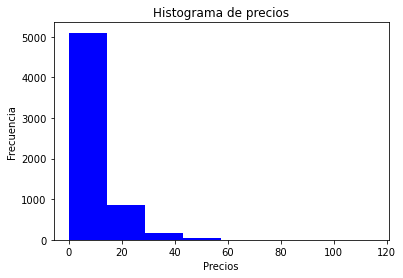

In [53]:
plt.hist(x=df_steam['price'], bins= 8,color= 'blue')
plt.title("Histograma de precios")
plt.xlabel('Precios')
plt.ylabel('Frecuencia')


plt.show()

In [61]:
df_steam.isnull().any().any()

False

In [63]:
df_steam.columns[df_steam.isnull().any()].tolist()

[]

<AxesSubplot:>

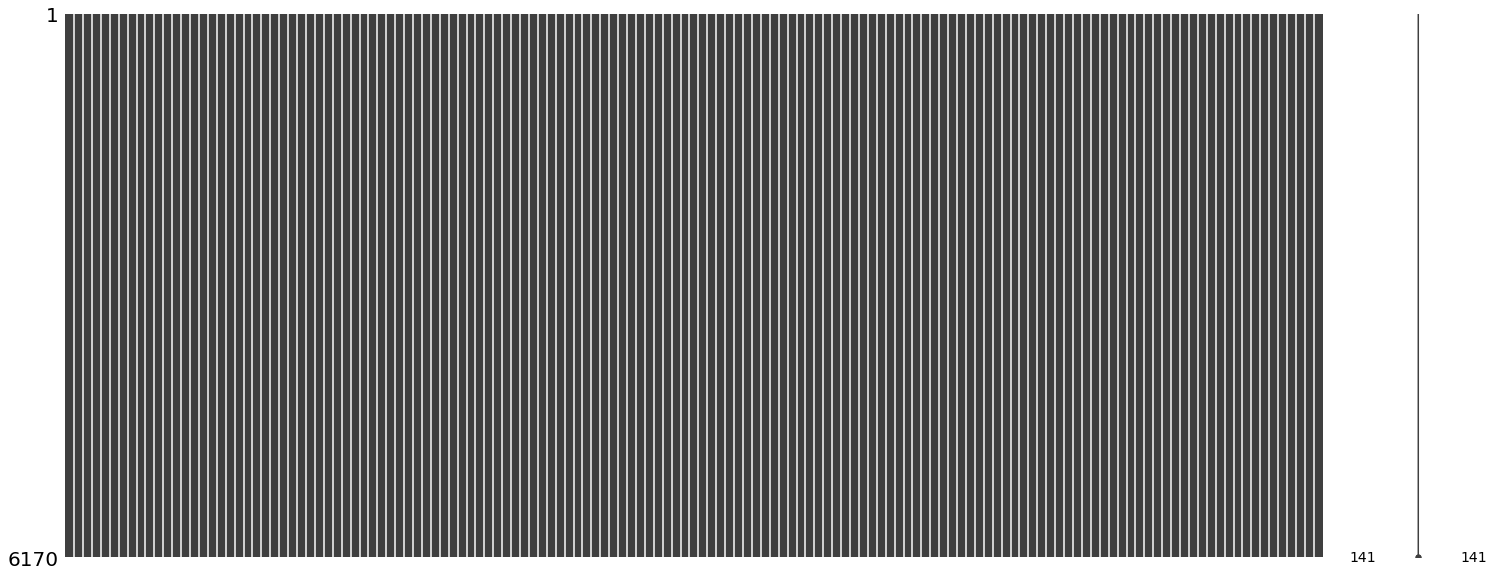

In [62]:
msno.matrix(df_steam)

In [67]:
df_steam.linux.value_counts()

False    4421
True     1749
Name: linux, dtype: int64

In [68]:
df_steam.mac.value_counts()

False    3737
True     2433
Name: mac, dtype: int64

In [69]:
np.logical_and(df_steam.mac.value_counts(),df_steam.linux.value_counts())

False    True
True     True
dtype: bool

## Limpieza e ingenieria de datos

In [7]:
dates = df_steam['release_date'].map(lambda x:x.split('-'))

df_steam['mesesDesdeLanzamiento'] = dates.map(lambda x : ((datetime.date(2019, 5, 1) - datetime.date(int(x[0]), int(x[1]), 1))/30).days )

df_steam['year'] = dates.map(lambda x:int(x[0]))
df_steam['month'] = dates.map(lambda x:int(x[1]))
#obtenemos el tiempo medio y el promedio entre el mes de lanzamiento

df_steam['average_playtime'] /= df_steam['mesesDesdeLanzamiento']
df_steam['median_playtime'] /= df_steam['mesesDesdeLanzamiento']

df_steam.drop('release_date', axis=1, inplace=True)

In [8]:
# Obtener el porcentaje del publico que gusto del juego y cuantos votaron
df_steam['rating'] = df_steam['positive_ratings'] / (df_steam['positive_ratings'] + df_steam['negative_ratings']) * 100
df_steam['rat_count'] = df_steam['positive_ratings'] + df_steam['negative_ratings']
df_steam.drop(['positive_ratings', 'negative_ratings'], axis=1, inplace=True)

In [9]:
# Pasar a cubetas la cantidad de dueños del juego
owners = ['0-20000', '20000-50000', '50000-100000', '100000-200000', '200000-500000', '500000-1000000', '1000000-2000000', '2000000-5000000', '5000000-10000000', '10000000-20000000', '20000000-50000000', '50000000-100000000', '100000000-200000000']
bucket_own = dict([(a, int(a.split('-')[1])) for a in owners])
# bucket_own = dict([(a, 1) for a in owners[:5]] + [(a, 2) for a in owners[5:9]] + [(a, 3) for a in owners[9:]])
df_steam.owners = df_steam.owners.replace(bucket_own)

In [10]:
# Todos los juegos se puede jugar en windows, por lo que se descarta
# Nos interesa saber si se pueden jugar en linux o mac
df_steam['linux'] = df_steam.platforms.map(lambda x:x.find('linux') >= 0)
df_steam['mac'] = df_steam.platforms.map(lambda x:x.find('mac') >= 0)
df_steam.drop('platforms', axis=1, inplace=True)

In [11]:
# Esta funcion permite obtener todas las palabras utlizadas para clasificar los juegos
# Si esta tiene un minimo de apariciones, se considerara como una palabra destacada
def extract_relevant_words(feature, min_samples=5):
    all_words = []
    for word in df_steam[feature].map(lambda x:x.split(';')):
        all_words += word
    all_words = pd.Series(all_words).value_counts()
    print(len(all_words))
    all_words = all_words[all_words > min_samples]
    return all_words

In [12]:
# One hot encoding de las palabras que clasifican el juego
# Agrega todas las columnas posibles y resalta las categorias en las que entra
def add_nominal_features(df, feature, words):
    new_words = df_steam[feature].map(lambda x:[w for w in x.split(';') if w in words])
    for w in words:
        df[feature[:3] + '_' + w] = 0
    for idx, words in enumerate(new_words):
        for w in words:
            df[feature[:3] + '_' + w].iloc[idx] = 1
    df.drop(feature, axis=1, inplace=True)
    return df

In [13]:
# Se obtienen las palabras relevantes de las categorias
all_dev = extract_relevant_words('developer', 10)
all_pub = extract_relevant_words('publisher', 20)
all_cat = extract_relevant_words('categories', 100)
all_gen = extract_relevant_words('genres')
all_tag = extract_relevant_words('tags', 50)
len(all_dev), len(all_pub), len(all_cat), len(all_gen), len(all_tag)

4336
2991
29
26
294


(33, 38, 21, 20, 54)

In [14]:
# Se agregan las columnas de las categorias como one hot encoding
print(df_steam.shape)

df_steam = add_nominal_features(df_steam, 'developer', all_dev.index)
print(df_steam.shape)

#  df_steam = add_nominal_features(df_steam, 'publisher', all_pub.index)
# print(df_steam.shape)
df_steam.drop('publisher', axis=1, inplace=True)

df_steam = add_nominal_features(df_steam, 'categories', all_cat.index)
print(df_steam.shape)

df_steam = add_nominal_features(df_steam, 'genres', all_gen.index)
print(df_steam.shape)

df_steam = add_nominal_features(df_steam, 'tags', all_tag.index)
print(df_steam.shape)

(6170, 18)
(6170, 50)
(6170, 69)
(6170, 88)
(6170, 141)


In [15]:
df_steam.head()

,name,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,year,month,rating,rat_count,linux,mac,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
0,Counter-Strike,0,78.275556,1.408889,20000000,7.19,225,2000,11,97.388815,127873,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Team Fortress Classic,0,1.135246,0.254098,10000000,3.99,244,1999,4,83.978740,3951,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Day of Defeat,0,0.963918,0.175258,10000000,3.99,194,2003,5,89.564761,3814,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Deathmatch Classic,0,1.183486,0.844037,10000000,3.99,218,2001,6,82.662338,1540,True,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Half-Life: Opposing Force,0,2.632911,1.751055,10000000,3.99,237,1999,11,94.799567,5538,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
df_steam.describe(percentiles=[.05, .25, .5, .75, .95])

,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,year,month,rating,rat_count,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
count,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.00000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000
mean,46.662723,27.780692,27.518271,7.236904e+05,7.472110,46.392545,

<AxesSubplot:>

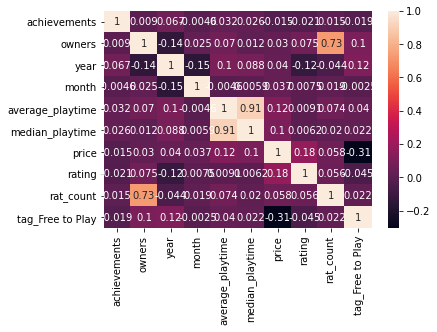

In [17]:
sns.heatmap(df_steam[['achievements', 'owners', 'year', 'month', 'average_playtime', 'median_playtime', 'price', 'rating', 'rat_count', 'tag_Free to Play']].corr(), annot=True)

In [18]:
df_steam.groupby('year').mean()

,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,month,rating,rat_count,linux,mac,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997,0.000000,0.048872,0.048872,1.000000e+05,5.990000,266.000000,6.000000,90.956072,387.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1998,0.000000,5.220884,0.333333,1.000000e+07,7.190000,249.000000,11.000000,96.187836,28855.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [19]:
df_steam.groupby('month').mean()

,achievements,average_playtime,median_playtime,owners,price,mesesDesdeLanzamiento,year,rating,rat_count,linux,mac,dev_Feral Interactive (Mac),dev_Valve,dev_EnsenaSoft,dev_Feral Interactive (Linux),dev_Square Enix,dev_Ubisoft Montreal,dev_Daedalic Entertainment,"dev_KOEI TECMO GAMES CO., LTD.",dev_Winged Cloud,dev_Team17 Digital Ltd,dev_LucasArts,dev_id Software,dev_Aspyr (Mac),dev_Just1337 Studio,dev_Double Fine Productions,dev_Bohemia Interactive,dev_Firaxis Games,dev_Capcom,"dev_CAPCOM Co., Ltd.",dev_Quiet River,dev_Creobit,dev_Forever Entertainment S. A.,dev_Arc System Works,dev_Relic Entertainment,dev_Gearbox Software,dev_Nival,dev_CREATIVE ASSEMBLY,dev_Paradox Development Studio,dev_Jetdogs Studios,dev_Traveller's Tales,dev_Crystal Dynamics,dev_Rebellion,dev_Amaterasu Software,cat_Single-player,cat_Steam Achievements,cat_Steam Trading Cards,cat_Steam Cloud,cat_Full controller support,cat_Multi-player,cat_Partial Controller Support,cat_Steam Leaderboards,cat_Online Multi-Player,cat_Co-op,cat_Stats,cat_Shared/Split Screen,cat_Steam Workshop,cat_Cross-Platform Multiplayer,cat_Includes level editor,cat_Online Co-op,cat_In-App Purchases,cat_Local Multi-Player,cat_Captions available,cat_MMO,cat_Local Co-op,gen_Indie,gen_Action,gen_Adventure,gen_Casual,gen_Strategy,gen_RPG,gen_Simulation,gen_Free to Play,gen_Early Access,gen_Massively Multiplayer,gen_Sports,gen_Racing,gen_Violent,gen_Gore,gen_Nudity,gen_Sexual Content,gen_Utilities,gen_Design & Illustration,gen_Animation & Modeling,gen_Web Publishing,tag_Indie,tag_Action,tag_Adventure,tag_Casual,tag_Strategy,tag_RPG,tag_Free to Play,tag_Simulation,tag_Early Access,tag_Multiplayer,tag_Puzzle,tag_Anime,tag_FPS,tag_Platformer,tag_Open World,tag_Horror,tag_Visual Novel,tag_Racing,tag_Point & Click,tag_Survival,tag_Massively Multiplayer,tag_Nudity,tag_Sports,tag_Pixel Graphics,tag_Sexual Content,tag_Space,tag_RTS,tag_Zombies,tag_Story Rich,tag_Sci-fi,tag_Female Protagonist,tag_Co-op,tag_Classic,tag_VR,tag_Shoot 'Em Up,tag_Gore,tag_Tower Defense,tag_Turn-Based,tag_Great Soundtrack,tag_Violent,tag_Arcade,tag_Fantasy,tag_Fighting,tag_Stealth,tag_Card Game,tag_Management,tag_Singleplayer,tag_World War II,tag_Turn-Based Strategy,tag_Hack and Slash,tag_JRPG,tag_Rogue-like,tag_Sandbox,tag_RPGMaker
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,37.853828,28.768178,27.851701,5.228306e+05,6.569350,43.378190,2015.728538,73.542254,3329.236659,0.280742,0.361949,0.004640,0.000000,0.000000,0.002320,0.000000,0.000000,0.004640,0.002320,0.004640,0.000000,0.000000,0.000000,0.000000,0.002320,0.006961,0.000000,0.000000,0.002320,0.009281,0.002320,0.000000,0.004640,0.004640,0.000000,0.000000,0.000000,0.000000,0.000000,0.002320,0.004640,0.000000,0.002320,0.002320,0.955916,0.587007,0.645012,0.361949,0.264501,0.162413,0.178654,0.160093,0.081206,0.085847,0.092807,0.078886,0.058005,0.051044,0.058005,0.041763,0.037123,0.048724,0.030162,0.027842,0.041763,0.726218,0.510441,0.415313,0.303944,0.190255,0.213457,0.132251,0.097448,0.067285,0.037123,0.034803,0.025522,0.037123,0.023202,0.013921,0.009281,0.002320,0.000000,0.000000,0.000000,0.512761,0.378190,0.227378,0.206497,0.146172,0.118329,0.099768,0.058005,0.067285,0.030162,0.046404,0.058005,0.013921,0.025522,0.044084,0.037123,0.039443,0.023202,0.018561,0.025522,0.018561,0.027842,0.018561,0.018561,0.023202,0.018561,0.018561,0.018561,0.018561,0.025522,0.013921,0.011601,0.020882,0.009281,0.013921,0.016241,0.011601,0.023202,0.011601,0.025522,0.006961,0.006961,0.009281,0.004640,0.004640,0.004640,0.004640,0.002320,0.006961,0.006961,0.006961,0.004640,0.011601,0.006961
2,44.981707,40.267807,29.923596,5.737602e+05,7.641728,40.619919,2015.869919,73.211212,4446.138211,0.278455,0.367886,0.010163,0.000000,0.000000,0.004065,0.008130,0.004065,0.000000,0.012195,0.002033,0.000000,0.002033,0.000000,0.002033,0.004065,0.002033,0.002033,0.002033,0.006098,0.002033,0.006098,0.000000,0.000000

## Feature selection

In [20]:
def get_train_test(scaler = StandardScaler()):
    X = df_steam.copy()
    # X.drop(['year', 'month'], axis=1, inplace=True)
    name = X.pop('name')
    y = X.pop('average_playtime'); X.drop('median_playtime', axis=1, inplace=True)
    # y = X.pop('median_playtime'); X.drop('average_playtime', axis=1, inplace=True)
    
    Xt, Xv, yt, yv = train_test_split(X, y, random_state = 12)    
    Xt = pd.DataFrame(scaler.fit_transform(Xt, yt), columns=Xt.columns)
    Xv = pd.DataFrame(scaler.transform(Xv), columns=Xv.columns)
    
    return Xt, Xv, yt, yv

### Backward elimination

In [21]:
Xt, Xv, yt, yv =  get_train_test()

X_new = Xt.copy()
y_ = list(yt.copy())
backward_features = list(X_new.columns)

while(len(backward_features) > 0):
    X_ = X_new[backward_features]
    X_ = sm.add_constant(X_)
    # Ordinary Least Squares (Linear regression)
    model = sm.regression.linear_model.OLS(y_, X_).fit()
    # pvalues
    p = pd.Series(model.pvalues.values[1:], index=backward_features)
    if(max(p) > 0.05):
        backward_features.remove(p.idxmax())
    else:
        break

Xt = Xt[backward_features]
Xv = Xv[backward_features]
print(len(backward_features))
print(backward_features)

# poly_fea = PolynomialFeatures(degree=1)
# Xt = poly_fea.fit_transform(Xt, yt)
# Xv = poly_fea.transform(Xv)

lin_reg = LinearRegression().fit(Xt, yt)

np.sqrt(mean_squared_error(lin_reg.predict(Xt), yt)), np.sqrt(mean_squared_error(lin_reg.predict(Xv), yv))

13
['achievements', 'owners', 'price', 'year', 'dev_Bohemia Interactive', 'cat_Steam Trading Cards', 'cat_Cross-Platform Multiplayer', 'cat_In-App Purchases', 'cat_MMO', 'tag_Open World', 'tag_Massively Multiplayer', 'tag_VR', 'tag_Sandbox']


(163.69993762062836, 237.76163715127697)

In [22]:
pd.DataFrame({'prediction': lin_reg.predict(Xv[:5]), 'value': yv[:5].values})

,prediction,value
0,72.795914,56.111111
1,52.102896,63.400000
2,7.601053,6.459459
3,86.964415,35.633333
4,11.093454,4.653846


### SelectKBest

In [23]:
Xt, Xv, yt, yv =  get_train_test(MinMaxScaler())

X_ = Xt.copy()
y_ = yt.copy()
k = 8
# selector = SelectKBest(chi2, k=k).fit(X_, y_)
selector = SelectKBest(mutual_info_regression, k=k).fit(X_, y_)
cols = selector.get_support(indices=True)
best_features = X_.columns[cols]
# kbest = pd.Series(selector.scores_, index=X_.columns).sort_values(ascending=False)[:k]
# kbest.plot(kind="bar")

Xt = Xt[best_features]
Xv = Xv[best_features]
print(k)
print(best_features)

# poly_fea = PolynomialFeatures(degree=1)
# Xt = poly_fea.fit_transform(Xt, yt)
# Xv = poly_fea.transform(Xv)

lin_reg = LinearRegression().fit(Xt, yt)

np.sqrt(mean_squared_error(lin_reg.predict(Xt), yt)), np.sqrt(mean_squared_error(lin_reg.predict(Xv), yv))

8
Index(['achievements', 'price', 'mesesDesdeLanzamiento', 'year', 'month',
       'rat_count', 'cat_Steam Trading Cards', 'gen_Free to Play'],
      dtype='object')


(167.0471471856667, 235.2484494111404)

In [24]:
pd.DataFrame({'prediction': lin_reg.predict(Xv[:5]), 'value': yv[:5].values})

,prediction,value
0,83.583896,56.111111
1,55.779678,63.400000
2,7.067839,6.459459
3,101.760337,35.633333
4,13.936346,4.653846


### Recursive Feature Elimination

In [25]:
Xt, Xv, yt, yv =  get_train_test()

X_ = Xt.copy()
high_score = 0
index = 0
for ite in range(X_.shape[1]):
    model = LinearRegression()
    rfe = RFE(model, ite+1)
    model.fit(rfe.fit_transform(Xt, yt), yt)
    score = model.score(rfe.transform(Xv), yv)
    if high_score < score:
        high_score = score
        index = ite+1
high_score, index

(0.010117389042171077, 4)

In [26]:
model = LinearRegression()
rfe = RFE(model, index)
model.fit(rfe.fit_transform(Xt, yt), yt)
rfe_features = pd.Series(rfe.support_, index=X_.columns)
X_new = X_[rfe_features[rfe_features == True].index]

rfe_features = X_new.columns
Xt = Xt[rfe_features]
Xv = Xv[rfe_features]

len(X_new.columns), np.sqrt(mean_squared_error(model.predict(Xt), yt)), np.sqrt(mean_squared_error(model.predict(Xv), yv))

(4, 168.3111977836717, 235.585597814141)

In [27]:
X_new.head()

,price,mesesDesdeLanzamiento,year,month
0,-0.403502,3.063364,-3.050204,0.425511
1,0.882846,-0.237793,0.376832,-1.350884
2,0.532024,-0.110826,-0.003950,1.017642
3,-0.403502,0.397045,-0.384732,-0.166621
4,-0.672465,-0.523470,0.376832,1.313708


In [28]:
pd.DataFrame({'prediction': model.predict(Xv[:5]), 'value': yv[:5].values})

,prediction,value
0,80.649667,56.111111
1,53.258563,63.400000
2,18.015606,6.459459
3,100.080203,35.633333
4,27.341323,4.653846


# Modelos

In [29]:
Xt, Xv, yt, yv =  get_train_test()

In [30]:
list_features = [
  Xt.columns,
  backward_features,
  best_features,
  rfe_features,
]

In [31]:
models = [
  LinearRegression(),
  SVR(),
  DecisionTreeRegressor(),
]

In [32]:
for model in models:
  print('*' * 50)
  for fea in list_features:
    model.fit(Xt[fea], yt)
    print(np.sqrt(mean_squared_error(model.predict(Xt[fea]), yt)), np.sqrt(mean_squared_error(model.predict(Xv[fea]), yv)))
    print()

**************************************************
162.37938978424515 239.5864377087823

163.69993762062836 237.76163715127697

167.04714718566694 235.2484494111406

168.3111977836717 235.585597814141

**************************************************
172.26784176197316 237.66615249138073

171.8493575702152 237.4298320863522

171.31070084788138 237.1159249995863

171.20145749952306 237.05296843932882

**************************************************
0.0 266.26908461648117

75.55724595592388 255.22269992240453

0.040054939296688186 277.99020598130727

111.29728798226276 250.83305407532518



In [33]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False],'n_jobs':[-1]}
grid_result_linear = GridSearchCV(models[0],parameters,scoring = 'neg_mean_squared_error',
                       return_train_score=True,verbose=1, n_jobs=-1)
grid_result_linear.fit(Xt,yt)
print ("Best score: ", grid_result_linear.best_score_)
print("Bets params: ", grid_result_linear.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score:  -30444.913739814474
Bets params:  {'fit_intercept': True, 'n_jobs': -1, 'normalize': False}


In [34]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

grid = GridSearchCV(models[1],
                    param_grid,
                    return_train_score=True,verbose=1, n_jobs=-1)
grid_result = grid.fit(Xt, yt)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score:  0.03552454006531973
Best Params:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [35]:
param_grid_tree = [{  'min_impurity_decrease':range(0,10),
                      'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
                      'min_samples_split':range(2,10),
                    'min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5]}]
grid_result_tree = GridSearchCV(models[2],
              param_grid_tree, cv=5, refit=True, n_jobs=-1)
grid_result_tree.fit(Xt,yt)
print ("Best score: ", grid_result_tree.best_score_)
print("Bets params: ", grid_result_tree.best_params_)

Best score:  0.015378497635611521
Bets params:  {'min_impurity_decrease': 5, 'min_samples_leaf': 0.2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.1}
